# D3. ENSEMBLE METHODS : RANDOM FOREST WITHOUT OUTLIERS

__3.1 Importing Libraries and Datasets__

__3.2 Random Forest Regressor__

__3.3 Model Evaluation : Training Mertrics__

__3.4 Model Evaluation : Cross Validation__

__3.5 Model Evaluation : Test Dataset__

__3.6 Feature Importances__

__3.7 Residuals' Distribution__

__3.8 Scatterplots with fitted line (Train Dataset)__

__3.9 Saving Results__

## 3.1 Importing Libraries and Datasets

In [1]:
# Libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 100)

In [2]:
# Train Dataset

train_data = pd.read_csv("BG_Train_Dataset_No_Outliers.csv") 
train_df = train_data.copy()
train_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,3.321,4.427,1.574,5.794,8.838,1,1,1,2,129


In [3]:
# Test Dataset

test_data = pd.read_csv("BG_Test_Dataset_No_Outliers.csv") 
test_df = test_data.copy()
test_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,3.728,5.596,0.0,7.543,8.058,0,0,2,2,115


## 3.2 Random Forest Regressor

In [4]:
# Defining X_train and Y_train

Y_train = train_df['Post Operative Glucose']
X_train = train_df.drop('Post Operative Glucose', axis = 1)
X_train.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,3.321,4.427,1.574,5.794,8.838,1,1,1,2


In [5]:
# Using the KFold function for cross-validation

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

In [6]:
# Defining Grid for Hyperparameter Tuning

grid = { 'n_estimators': [10,20,30,40,50,80,100],
        'max_depth' : [2,4,6,8,10,12, None],
        'min_samples_split' : [2,4,6,8],
        'min_samples_leaf' : [2,4,6,8],
        'max_features' : ['sqrt', 0.15, 0.5],
        'max_leaf_nodes' : [4,6,8,10],
        'bootstrap': [True, False]}

In [7]:
# Instantiating GridSearchCV 

RF_search = GridSearchCV(RandomForestRegressor(random_state = 126), 
                         grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, verbose = 1)

In [8]:
# Searching for the best parameters for Random Forest

CV_RF_results = RF_search.fit(X_train, Y_train)

Fitting 5 folds for each of 18816 candidates, totalling 94080 fits


In [9]:
# Displaying the best parameters 

RF_Best_Parameters = pd.DataFrame(CV_RF_results.best_params_,
                                  index = ['Best Random Forest Regressor Parameters'])

RF_Best_Parameters = RF_Best_Parameters.transpose()
RF_Best_Parameters

,Best Random Forest Regressor Parameters
bootstrap,True
max_depth,4
max_features,sqrt
max_leaf_nodes,10
min_samples_leaf,8
min_samples_split,2
n_estimators,20


In [10]:
# Storing the values of the best parameters

best_n_estimators = CV_RF_results.best_params_['n_estimators']
best_max_depth = CV_RF_results.best_params_['max_depth']
best_min_samples_split = CV_RF_results.best_params_['min_samples_split']
best_min_samples_leaf = CV_RF_results.best_params_['min_samples_leaf']
best_max_features = CV_RF_results.best_params_['max_features']
best_bootstrap = CV_RF_results.best_params_['bootstrap']
best_max_leaf_nodes = CV_RF_results.best_params_['max_leaf_nodes']


## 3.3 Model Evaluation : Training Metrics

In [11]:
# Instantiating the best Random Forest Model

RandomForestModel = RandomForestRegressor(random_state = 126,
                                 max_depth = best_max_depth,
                                 n_estimators = best_n_estimators, 
                                 min_samples_split = best_min_samples_split, 
                                 min_samples_leaf = best_min_samples_leaf,
                                 bootstrap = best_bootstrap,
                                 max_leaf_nodes = best_max_leaf_nodes,
                                          max_features = best_max_features).fit(X_train,Y_train)


In [12]:
# Getting the R^2

RF_R2 = np.round(RandomForestModel.score(X_train,Y_train),3)

In [13]:
# Getting predictions and training metrics 

RFPredictions = RandomForestModel.predict(X_train)
RFFeats = RandomForestModel.n_features_in_
RF_Tr_MAE = np.round(mean_absolute_error(Y_train, RFPredictions),3)

In [14]:
# Dictionary the holds the information of  R^2, number of predictors and training metrics

dict1 = {'Random Forest Regressor' : [RF_R2, RFFeats, RF_Tr_MAE]}

In [15]:
# Creating a dataframe to easily present the results 

Training_metric_df = pd.DataFrame(dict1, index=['R^2','Num_of_Feats','Tr_MAE'])

In [16]:
# Displaying the training evaluation metrics

Training_metric_df

,Random Forest Regressor
R^2,0.428
Num_of_Feats,9.000
Tr_MAE,15.965


## 3.4 Model Evaluation : Cross Validation

In [17]:
# Function that calculates the cross validated test MAE 

def cv_scores(X,Y, model,cv):
        
    cv_MAE = round(np.mean(cross_val_score(model, X, Y, cv=cv, 
                                       scoring='neg_mean_absolute_error', 
                                           error_score='raise') * (-1)),2)

    
    score = cv_MAE
    return score

In [18]:
# Dictionary that holds the information of the cross validated test MAE  

dict2 = {'Random Forest Regressor':cv_scores(X_train,Y_train, RandomForestModel,cv)}

In [19]:
# Creating a dataframe to easily present the results 

Test_CV_results = pd.DataFrame(dict2, index=['Te_MAE (KFold)'])

# Displaying the cross validated test error results

Test_CV_results

,Random Forest Regressor
Te_MAE (KFold),18.12


## 3.5 Model Evaluation : Test Dataset

In [20]:
# Defining X_test and Y_test

Y_test = test_df['Post Operative Glucose']
X_test = test_df.drop('Post Operative Glucose', axis = 1)
X_test.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,3.728,5.596,0.0,7.543,8.058,0,0,2,2


In [21]:
# Getting predictions

RF_predictions = RandomForestModel.predict(X_test)

In [22]:
# Getting Test Metrics

RF_Te_MAE = round(mean_absolute_error(Y_test, RF_predictions),2)

In [23]:
# Dictionary that holds the information of test MAE  

dict3 = {'Random Forest Regressor':[RF_Te_MAE]}

In [24]:
# Creating a dataframe to easily present the results 

Test_Dat_results = pd.DataFrame(dict3, index=['Te_MAE'])

In [25]:
# Displaying the test error results

Test_Dat_results

,Random Forest Regressor
Te_MAE,19.53


## 3.6 Feature Importances

In [26]:
# load JS visualization code to notebook

shap.initjs()

In [27]:
# Instantiating and fitting the best model 

model = RandomForestRegressor(random_state = 126,
                                 max_depth = best_max_depth,
                                 n_estimators = best_n_estimators, 
                                 min_samples_split = best_min_samples_split, 
                                 min_samples_leaf = best_min_samples_leaf,
                                 bootstrap = best_bootstrap,
                                 max_leaf_nodes = best_max_leaf_nodes,
                                          max_features = best_max_features)
model.fit(X_train, Y_train);

In [28]:
# Creating the explainer

explainer = shap.TreeExplainer(model, X_train);

In [29]:
# Calculate Shapley values for the data

shap_values = explainer(X_train)

In [30]:
# Picking a color for the graphs

color = 'fuchsia'

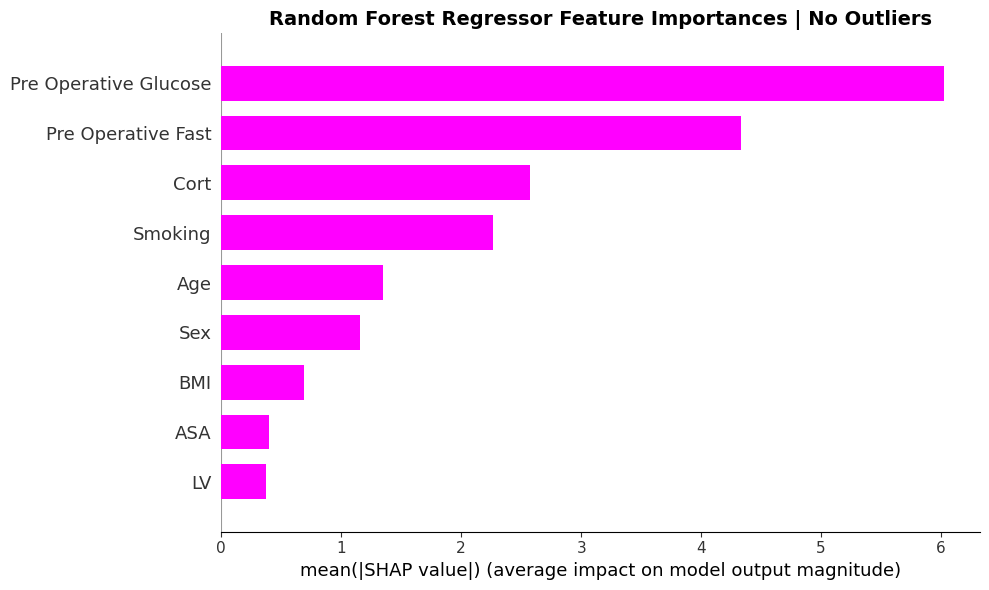

In [31]:
# Plot summary plot to visualize feature importance

plt.title(label = "Random Forest Regressor Feature Importances | No Outliers" , fontsize = 14, weight = 'bold')

shap.summary_plot(shap_values, X_train, feature_names = X_train.columns, 
                  plot_type='bar', 
                  color= color, plot_size= (10,6))

plt.show()

## 3.7 Residuals' Distribution

In [32]:
# Models' fitted values

fitted_y1 = RFPredictions

# Models' residuals

residuals1 = Y_train - RFPredictions

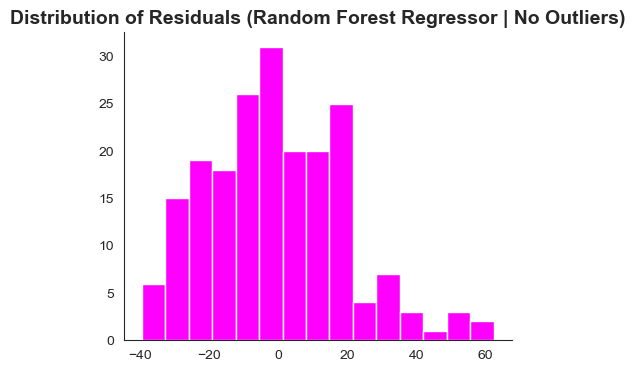

In [33]:
# Histogram of residuals 

sns.set_style("white")
    
plt.figure(figsize=(5,4))
    
plt.hist(residuals1, bins = 15, color = color)
    
plt.title(label = "Distribution of Residuals (Random Forest Regressor | No Outliers)" , fontsize = 14, weight = 'bold')
    
sns.despine()
    
plt.show()

## 3.8 Scatterplots with fitted line (Train Dataset)

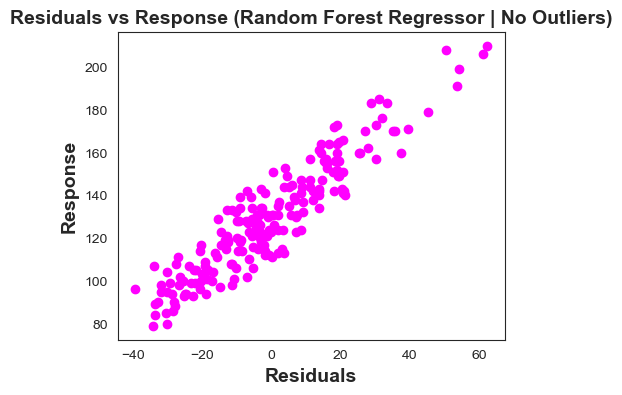

In [34]:
# Plotting residuals vs response 

sns.set_style("white")

plt.figure(figsize=(5,4))

plt.plot(residuals1, Y_train, 'o', color = color)

# Uncomment the following lines to add a fitted line
# b,a = np.polyfit(residuals1, Y_train, 1)

# plt.plot(residuals1, b*residuals1 + a, color = 'black')

plt.title(label = 'Residuals vs Response (Random Forest Regressor | No Outliers)', fontsize = 14, weight = 'bold')
plt.xlabel('Residuals',fontsize = 14, weight = 'bold')
plt.ylabel('Response',fontsize = 14, weight = 'bold')

plt.show()

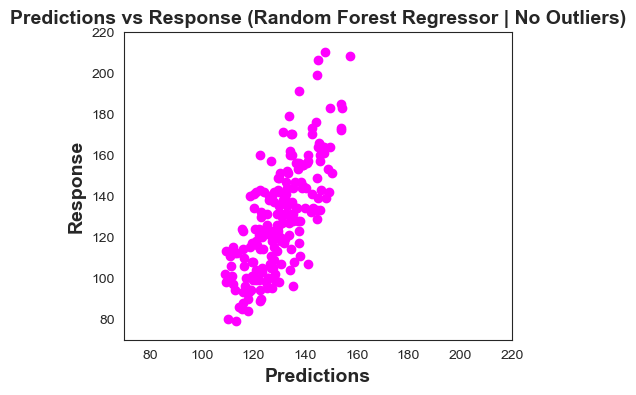

In [35]:
# Plotting predictions vs response 

sns.set_style("white")

plt.figure(figsize=(5,4))

plt.plot(RFPredictions, Y_train, 'o', color = color)

# Uncomment the following lines to add a fitted line
# b,a = np.polyfit(RFPredictions, Y_train, 1)

# plt.plot(RFPredictions, b*RFPredictions + a, color = 'black')

plt.title(label = 'Predictions vs Response (Random Forest Regressor | No Outliers)', fontsize = 14, weight = 'bold')
plt.xlabel('Predictions',fontsize = 14, weight = 'bold')
plt.ylabel('Response',fontsize = 14, weight = 'bold')


plt.xlim(70, 220)
plt.ylim(70, 220)

plt.show()

## 3.9 Saving Results

In [36]:
# Concatenating the training and test Dataframes

RFResults = pd.concat([Training_metric_df, Test_CV_results,Test_Dat_results], axis =  0)
RFResults

,Random Forest Regressor
R^2,0.428
Num_of_Feats,9.000
Tr_MAE,15.965
Te_MAE (KFold),18.120
Te_MAE,19.530


In [37]:
# Saving the Results

RFResults.to_csv(r'RandomForestResultsNoOutliers.csv', index=True, index_label = 'Metric')